In [1]:
# http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/

# http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera16itsc.pdf
# pdf contains description of data (what each column means)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import os
import folium
from geopy.distance import distance
import datetime

from ride_parser import UAHRideParser, RealRideParser
from app_data_parser import get_data_from_app
from PIL import Image

In [2]:
def foo(accelerometer_df, frame_granularity, delta_time_size, img_id):
    fig, axs = plt.subplots(ncols=1, nrows=3)

    lower_limit = frame_granularity * img_id 
    upper_limit = frame_granularity * img_id + delta_time_size
    # print("low up", lower_limit, upper_limit)
    time_filter = (accelerometer_df.timestamp >= lower_limit) & (accelerometer_df.timestamp < upper_limit)
    filtered_accelerations_df = accelerometer_df[time_filter]

    acc_x = filtered_accelerations_df["acc_x"]
    acc_y = filtered_accelerations_df["acc_y"]
    acc_z = filtered_accelerations_df["acc_z"]
    timestamp = filtered_accelerations_df["timestamp"]

    # axs[0].scatter(timestamp, acc_x, s=0.1)
    axs[0].plot(timestamp, filtered_accelerations_df["acc_x"], label="acc_x")
    axs[0].plot(timestamp, filtered_accelerations_df["filtered_acc_x"], label="filt_acc_x")
    axs[0].legend(loc='right')
    axs[0].set_title("acc_x")

    axs[1].plot(timestamp, acc_y)
    axs[1].plot(timestamp, filtered_accelerations_df["filtered_acc_y"])
    axs[1].set_title("acc_y")

    axs[2].plot(timestamp, acc_z)    
    axs[2].plot(timestamp, filtered_accelerations_df["filtered_acc_z"])
    axs[2].set_title("acc_z")

    for ax in axs:
        ax.set_ylim(-0.2, 0.2)
        ax.set_xlim(lower_limit, upper_limit)

    # axs.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

    # fig.ylim(-0.2, 0.2)
    fig.tight_layout()

    imgs_path = os.path.join(ride_root_dir, "images")
    path_exists = os.path.exists(imgs_path)
    if not path_exists:
        os.makedirs(imgs_path)

    fig_name = os.path.join(imgs_path, "fig_%02d" % img_id)
    fig.savefig(fig_name)

    plt.close(fig)

In [3]:
def foo_for_real_data(accelerometer_df, frame_granularity, delta_time_size, img_id):
    fig, axs = plt.subplots(ncols=1, nrows=3)

    lower_limit = frame_granularity * img_id 
    upper_limit = frame_granularity * img_id + delta_time_size
    # print("low up", lower_limit, upper_limit)
    time_filter = (accelerometer_df.timestamp >= lower_limit) & (accelerometer_df.timestamp < upper_limit)
    filtered_accelerations_df = accelerometer_df[time_filter]

    acc_x = filtered_accelerations_df["acc_x"]
    acc_y = filtered_accelerations_df["acc_y"]
    acc_z = filtered_accelerations_df["acc_z"]
    timestamp = filtered_accelerations_df["timestamp"]

    # axs[0].scatter(timestamp, acc_x, s=0.1)
    axs[0].plot(timestamp, filtered_accelerations_df["acc_x"], label="acc_x")
    axs[0].plot(timestamp, filtered_accelerations_df["filtered_acc_x"], label="filt_acc_x")
    axs[0].legend(loc='right')
    axs[0].set_title("acc_x")

    axs[1].plot(timestamp, acc_y)
    axs[1].plot(timestamp, filtered_accelerations_df["filtered_acc_y"])
    axs[1].set_title("acc_y")

    axs[2].plot(timestamp, acc_z)    
    axs[2].plot(timestamp, filtered_accelerations_df["filtered_acc_z"])
    axs[2].set_title("acc_z")

    for ax in axs:
        ax.set_ylim(-10, 10)
        ax.set_xlim(lower_limit, upper_limit)

    # axs.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))

    # fig.ylim(-0.2, 0.2)
    fig.tight_layout()

    imgs_path = os.path.join(ride_root_dir, "images")
    path_exists = os.path.exists(imgs_path)
    if not path_exists:
        os.makedirs(imgs_path)

    fig_name = os.path.join(imgs_path, "fig_%02d" % i)
    fig.savefig(fig_name)

    plt.close(fig)

In [4]:
ride_root_dir = os.path.join("RealData")

real_ride = RealRideParser(ride_root_dir)

real_ride.gps_df.dtypes
# ride.gps_df
# ride.accelerometer_df

timestamp               float64
original_time_string     object
lat                     float64
long                    float64
dtype: object

In [5]:
latitudes = real_ride.gps_df["lat"]
longitudes = real_ride.gps_df["long"]

qtty_data = len(latitudes)

lat_longs = [(latitudes.iloc[i], longitudes.iloc[i]) for i in range(qtty_data)]

In [6]:
start_lat_long = lat_longs[0]
end_lat_long = lat_longs[-1]

mean_lat = latitudes.mean()
mean_long = longitudes.mean()

start_lat_long, end_lat_long, qtty_data

((-23.5523206, -46.6656069), (-23.5523127, -46.6656244), 192)

In [7]:
map = folium.Map(location=[mean_lat, mean_long], zoom_start=14, control_scale=True)

folium.Marker(start_lat_long, popup="start").add_to(map)
folium.Marker(end_lat_long, popup="end").add_to(map)

In [8]:
for i in range(qtty_data - 1):
	location_1 = lat_longs[i]
	location_2 = lat_longs[i + 1]

	folium.PolyLine([location_1, location_2],
					color='red',
					weight=5,
					opacity=0.4).add_to(map)

map

In [15]:
accelerometer_df = real_ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 40 * 1000 	# 20 s
frame_granularity = 20 * 1000 	# 1 s
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

filtered_accelerations_df = accelerometer_df

print("oldest_timestamp", oldest_timestamp)
print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

foo_for_real_data(accelerometer_df, frame_granularity, delta_time_size, 0)

# for i in range(qtty_frames):
#     foo(accelerometer_df, frame_granularity, delta_time_size, i)


oldest_timestamp 1699030179
qtty_frames 42474
oldest_timestamp 1699030179


Objetivos:
- [] Gerar mapa com a rota feita por cada um dos motoristas
- [] Sincronizar vídeo com eventos de aceleração

In [10]:
# ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151110175712-16km-D1-NORMAL1-SECONDARY")
ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151111125233-24km-D1-AGGRESSIVE-MOTORWAY")

ride = UAHRideParser(ride_root_dir)

# col_names = [str(i) for i in range(13)]
# col_names = ["timestamp", "speed", "lat", "long", "altitude", "vert accuracy", "horiz accuracy", "course", "difcourse", "?1", "?2", "?3", "?4"]
# pd.read_csv(gps_file_path, sep=" ", names=col_names)

ride.gps_df
ride.accelerometer_df

,timestamp,is speed gt 50 kmh,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,roll_degrees,pitch_degrees,yaw_degrees,?1,?2,?3,?4
0,8.02,1,-0.013,-0.021,0.011,-0.031,-0.009,0.013,-1.627,-0.011,0.294,NaN,NaN,NaN,NaN
1,8.12,1,-0.008,-0.005,-0.017,-0.018,-0.011,0.002,-1.626,-0.007,0.297,NaN,NaN,NaN,NaN
2,8.22,1,-0.013,-0.026,-0.012,-0.005,-0.011,-0.008,-1.625,-0.003,0.299,NaN,NaN,NaN,NaN
3,8.32,1,-0.049,-0.018,0.033,-0.029,-0.018,0.002,-1.626,0.001,0.302,NaN,NaN,NaN,NaN
4,8.43,1,0.016,0.009,0.014,-0.021,-0.008,0.021,-1.627,0.004,0.304,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,745.45,1,0.004,-0.009,0.019,-0.003,-0.017,0.009,-1.527,0.010,-2.639,NaN,NaN,NaN,NaN
7283,745.55,1,-0.013,-0.019,-0.049,0.004,-0.033,-0.005,-1.525,0.015,-2.636,NaN,NaN,NaN,NaN
7284,745.65,1,-0.082,-0.012,0.001,-0.043,-0.007,-0.024,-1.526,0.014,-2.637,NaN,NaN,NaN,NaN
7285,745.75,1,-0.041,-0.037,0.025,-0.052,-0.021,0.010,-1.528,0.014,-2.632,NaN,NaN,NaN,NaN


In [11]:
accelerometer_df = ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 20
frame_granularity = 1
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

for i in range(qtty_frames):
    with ProcessPoolExecutor(max_workers=10) as executor:
        future = executor.submit(foo, accelerometer_df, frame_granularity, delta_time_size, i)

    # print(future.result())

# plt.show()
# RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

qtty_frames 725
oldest_timestamp 745


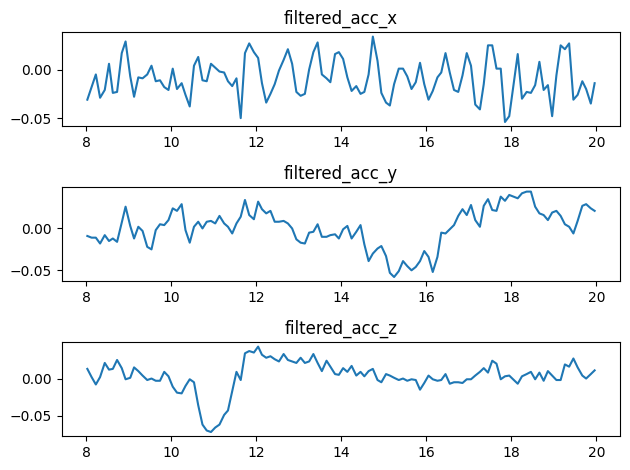

In [12]:
fig, axs = plt.subplots(ncols=1, nrows=3)

accelerometer_df = ride.accelerometer_df
accelerometer_df = accelerometer_df[accelerometer_df.timestamp < 20]
filtered_acc_x = accelerometer_df["filtered_acc_x"]
filtered_acc_y = accelerometer_df["filtered_acc_y"]
filtered_acc_z = accelerometer_df["filtered_acc_z"]
timestamp = accelerometer_df["timestamp"]

# axs[0].scatter(timestamp, filtered_acc_x, s=0.1)
axs[0].plot(timestamp, filtered_acc_x) #, "-o")
axs[0].set_title("filtered_acc_x")

axs[1].plot(timestamp, filtered_acc_y)
axs[1].set_title("filtered_acc_y")

axs[2].plot(timestamp, filtered_acc_z)
axs[2].set_title("filtered_acc_z")

fig.tight_layout()

plt.show()

In [13]:
app_data = get_data_from_app()

velocities = app_data["SPEED"]
plt.plot(velocities["timestamp"], velocities["SPEED"])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '..\\Dados_app\\DELETEME.txt'

In [ ]:
imgs = ride.generate_acc_sub_graph()

# im = Image.open(next(imgs))
# im.show(title="My Image")

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# import numpy
# from PIL import Image

# n = 20

# img = [] # some array of images
# for i in range(n):
# 	imarray = numpy.random.rand(100,100,3) * 255
# 	im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
# 	img.append(im)

# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(n):
# 	frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, blit=True)

# writergif = animation.PillowWriter(fps=1)
# ani.save('movie.gif', writer=writergif)
# plt.show()

In [ ]:
# import io
# from PIL import Image
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# plt.figure()
# plt.plot([1, 2])

# img_buf = io.BytesIO()
# plt.savefig(img_buf, format='png')

# im = Image.open(img_buf)
# im.show(title="My Image")

# img_buf.close()